In [3]:
import os
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow import keras 
from sklearn.model_selection import train_test_split
import tensorflow 
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import Sequential, Input
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.layers import Conv2D, Flatten
from tensorflow.keras.layers import InputLayer, BatchNormalization,Activation, MaxPool2D
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.applications import ResNet101
import tqdm
import keras
import glob
import cv2
import warnings
from keras.preprocessing import image
import numpy as np
warnings.filterwarnings("ignore")
import scipy
print("Num GPUs Available: ", len(tensorflow.config.list_physical_devices('GPU')))
seed = 1842
tensorflow.random.set_seed(seed)
np.random.seed(seed)

Num GPUs Available:  0


In [4]:
batch_size=60
img_size=(224,224)
image_generator = ImageDataGenerator(rescale=1/255., validation_split=0) #shear_range =.25, zoom_range =.2, horizontal_flip = True, rotation_range=20)     
train_data = image_generator.flow_from_directory(batch_size=batch_size,directory='F:\Alzheimer_s Dataset\\train',shuffle=True,target_size=img_size, subset="training",class_mode='categorical')

image_generator = ImageDataGenerator(rescale=1/255,validation_split=0.2) 
validation_data= image_generator.flow_from_directory(batch_size=batch_size,directory='F:\Alzheimer_s Dataset\\test',shuffle=True,target_size=img_size,class_mode='categorical')

submission = image_generator.flow_from_directory(directory='F:\Alzheimer_s Dataset\\test',shuffle=False,subset="validation",target_size=img_size, class_mode=None)

Found 5121 images belonging to 4 classes.
Found 1279 images belonging to 4 classes.
Found 254 images belonging to 4 classes.


In [5]:
train_data.class_indices

{'MildDemented': 0,
 'ModerateDemented': 1,
 'NonDemented': 2,
 'VeryMildDemented': 3}

In [6]:
batch_size=60
epoch=10
callback= keras.callbacks.EarlyStopping(monitor='val_loss',patience=8,restore_best_weights=True)

In [7]:
rn101 = ResNet101(input_shape=(224,224,3), weights='imagenet', include_top=False)
for layer in rn101.layers:
    layer.trainable = False
x = Flatten()(rn101.output)
x = Dense(128, activation='relu')(x)
out = Dense(4, activation='softmax')(x)

modelrn101= Model(inputs=rn101.input, outputs=out)

# Compiling
modelrn101.compile(optimizer='adam',
                   loss='categorical_crossentropy',
                   metrics=['accuracy'])

#Summary
modelrn101.summary()

171446536/171446536 [==============================] - 58s 0us/step
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 230, 230, 3)          0         ['input_1[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, 112, 112, 64)         9472      ['conv1_pad[0][0]']           
                                                                                                  
 conv1_bn (BatchNormalizati  (None, 112, 112, 64)         256       ['conv1_conv[0][0]']          
 on)                      

In [8]:
hist_rn101=modelrn101.fit(train_data, epochs=epoch, validation_data=validation_data, callbacks=callback)

Epoch 1/10
86/86 [==============================] - 817s 9s/step - loss: 3.0014 - accuracy: 0.4712 - val_loss: 0.9804 - val_accuracy: 0.5528
Epoch 2/10
86/86 [==============================] - 668s 8s/step - loss: 0.9464 - accuracy: 0.5716 - val_loss: 0.9362 - val_accuracy: 0.5442
Epoch 3/10
86/86 [==============================] - 681s 8s/step - loss: 0.9734 - accuracy: 0.5614 - val_loss: 1.0589 - val_accuracy: 0.4957
Epoch 4/10
86/86 [==============================] - 680s 8s/step - loss: 0.9287 - accuracy: 0.5829 - val_loss: 0.9823 - val_accuracy: 0.5410
Epoch 5/10
86/86 [==============================] - 1500s 18s/step - loss: 0.8675 - accuracy: 0.6167 - val_loss: 1.0075 - val_accuracy: 0.5739
Epoch 6/10
86/86 [==============================] - 661s 8s/step - loss: 0.8657 - accuracy: 0.6208 - val_loss: 0.8852 - val_accuracy: 0.5927
Epoch 7/10
86/86 [==============================] - 986s 12s/step - loss: 0.7529 - accuracy: 0.6635 - val_loss: 0.8807 - val_accuracy: 0.5919
Epoch 8/10

In [9]:
loss_rn101,accuracy_rn101= modelrn101.evaluate(validation_data)

22/22 [==============================] - 131s 6s/step - loss: 1.0456 - accuracy: 0.5551


In [13]:
batch_size = 1
test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_directory('F:\Alzheimer_s Dataset\\test',color_mode = "rgb",target_size=(224, 224),batch_size=1, shuffle=True)
y_pred = modelrn101.predict_generator(test_generator, 1//batch_size, workers=4)

Found 1279 images belonging to 4 classes.


In [14]:
label_dict = {0: 'MildDemented', 1: 'ModerateDemented',2: 'NonDemented', 3: 'VeryMildDemented'}

1/1 [==============================] - 2s 2s/step
[[2.1356465e-02 1.7848394e-04 8.7679160e-01 1.0167343e-01]]


Text(0.5, 1.0, 'NonDemented')

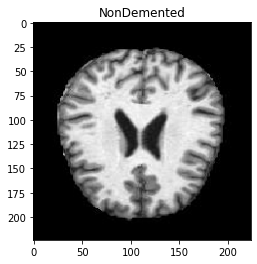

In [15]:
x_test, y_test = next(test_generator)
p = modelrn101.predict(x_test)
print(p)
p = p.argmax()
plt.imshow(x_test[0])
plt.title(label_dict[p])

In [16]:
path="F:\Alzheimer_s Dataset\\train\MildDemented\\mildDem0.jpg"
img=image.load_img(path,target_size=(224,224))

img=image.img_to_array(img)/224
img=np.array([img])
img.shape

(1, 224, 224, 3)

In [17]:
Y_pred = modelrn101.predict_generator(validation_data, 1000 // batch_size+1)
y_pred = np.argmax(Y_pred, axis=1)
print('Confusion Matrix')
print(confusion_matrix(validation_data.classes, y_pred))
print('Classification Report')
target_names = ['MildDemented',  'ModerateDemented','NonDemented', 'VeryMildDemented']
print(classification_report(validation_data.classes, y_pred, target_names=target_names))

Confusion Matrix
[[  1   0 148  30]
 [  0   0  11   1]
 [  4   0 522 114]
 [  2   0 370  76]]
Classification Report
                  precision    recall  f1-score   support

    MildDemented       0.14      0.01      0.01       179
ModerateDemented       0.00      0.00      0.00        12
     NonDemented       0.50      0.82      0.62       640
VeryMildDemented       0.34      0.17      0.23       448

        accuracy                           0.47      1279
       macro avg       0.25      0.25      0.21      1279
    weighted avg       0.39      0.47      0.39      1279

